In [1]:
import xarray as xr
import pandas as pd
import progressbar
import numpy as np
from oggm.utils import mkdir
import matplotlib.pyplot as plt

In [2]:
cd '/home/www/fmaussion/runs/runs_diff_calib_protect/output_1.6'

/home/www/fmaussion/runs/runs_diff_calib_protect/output_1.6


In [3]:
#%pwd

### GCMs - missing glaciers overview 

In [4]:
dirpath = './'

In [5]:
import os
allfiles = []
for root, dirs, files in os.walk(dirpath):
    for file in files:
        if file.endswith(".nc"):
             allfiles.append(os.path.join(root, file))

In [6]:
allfiles = sorted(allfiles)
allfiles[:10]

['./match_geod_pergla_1.6_qc0/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp126.nc',
 './match_geod_pergla_1.6_qc0/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp245.nc',
 './match_geod_pergla_1.6_qc0/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp370.nc',
 './match_geod_pergla_1.6_qc0/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp585.nc',
 './match_geod_pergla_1.6_qc0/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp119.nc',
 './match_geod_pergla_1.6_qc0/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp126.nc',
 './match_geod_pergla_1.6_qc0/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp245.nc',
 './match_geod_pergla_1.6_qc0/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp370.nc',
 './match_geod_pergla_1.6_qc0/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp585.nc',
 './match_geod_pergla_1.6_qc0/RGI01/CESM2-WACCM/CESM2-WACCM_ssp126.nc']

In [7]:
rgi_meta = pd.read_hdf('/home/www/oggm/rgi/rgi62_stats.h5')

In [8]:
rgi_meta = rgi_meta.loc[rgi_meta.Connect != 2]

In [10]:
df_meta = pd.DataFrame()
invalid_per_reg = {}  
meta_per_reg = {}

for f in progressbar.progressbar(allfiles):
    ename = f.replace('./', '')
    ss = ename.split('/')
    exp = ss[0]
    rgi_reg = ss[1]
    gcm = ss[2]
    ssp = ename.split('.')[-2].split('_')[-1]
    
    if ssp not in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:
        continue
    
    run_id = f'{exp}:{gcm}:{ssp}:{rgi_reg}'
    df_meta.loc[run_id, 'exp'] = exp
    df_meta.loc[run_id, 'gcm'] = gcm
    df_meta.loc[run_id, 'ssp'] = ssp
    df_meta.loc[run_id, 'rgi_reg'] = rgi_reg
    df_meta.loc[run_id, 'end_year'] = 0
    df_meta.loc[run_id, 'perc_area_missing'] = 0
    df_meta.loc[run_id, 'fpath'] = f
    
    if rgi_reg not in invalid_per_reg:
        invalid_per_reg[rgi_reg] = set()
    
    if rgi_reg not in meta_per_reg:
        meta_per_reg[rgi_reg] = rgi_meta.loc[rgi_meta['O1Region'] == rgi_reg[-2:]]
    
    with xr.open_dataset(f) as ds:
        df_meta.loc[run_id, 'end_year'] = int(ds.time[-1])
        missing_ids = ds.rgi_id[ds.isel(time=-1).volume.load().isnull()].data
        perc = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum() / meta_per_reg[rgi_reg]['Area'].sum() 
        df_meta.loc[run_id, 'perc_area_missing'] = perc
        invalid_per_reg[rgi_reg] = invalid_per_reg[rgi_reg].union(missing_ids)

100% (4788 of 4788) |####################| Elapsed Time: 0:06:18 Time:  0:06:18


In [11]:
dds = df_meta.sort_values('perc_area_missing', ascending=False)
dds[dds['perc_area_missing'] > 0.05].rgi_reg.unique()

array(['RGI12', 'RGI13'], dtype=object)

In [12]:
#df_meta.to_csv('agg/metadata.csv')

In [13]:
df_meta.groupby('exp')['perc_area_missing'].mean()

exp
match_geod_pergla_1.6_qc0       0.008453
match_geod_pergla_1.6_qc3       0.008456
match_geod_pergla_2.6           0.015293
match_geod_pergla_winterprcp    0.008727
Name: perc_area_missing, dtype: float64

In [15]:
for k, v in invalid_per_reg.items():
    invalid_per_reg[k] = list(v)

In [20]:
#import json
#with open('agg/rgi_ids_missing.json', 'w') as f:
#    json.dump(invalid_per_reg, f)

In [16]:
odf = pd.DataFrame()
for rgi_reg, missing_ids in invalid_per_reg.items():
    odf.loc[rgi_reg, 'n_glaciers'] = len(meta_per_reg[rgi_reg])
    odf.loc[rgi_reg, 'n_missing_glaciers'] = len(missing_ids)
    odf.loc[rgi_reg, 'rgi_area'] = meta_per_reg[rgi_reg]['Area'].sum() 
    odf.loc[rgi_reg, 'missing_area'] = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum()
    odf.loc[rgi_reg, 'missing_perc'] = odf.loc[rgi_reg, 'missing_area'] / odf.loc[rgi_reg, 'rgi_area']
odf[['n_glaciers', 'n_missing_glaciers']] = odf[['n_glaciers', 'n_missing_glaciers']].astype(int)
odf

n_glaciers  n_missing_glaciers    rgi_area  missing_area  missing_perc
RGI01       27108                  37   86725.053      2841.780      0.032768
RGI02       18855                  89   14524.224         3.846      0.000265
RGI03        4556                  45  105110.642        22.990      0.000219
RGI04        7415                  82   40888.228        25.771      0.000630
RGI05       19306                 175   89717.066       655.600      0.007307
RGI06         568                   3   11059.700         0.447      0.000040
RGI07        1615                   6   33958.934       230.013      0.006773
RGI08        3417                   8    2949.103         0.325      0.000110
RGI09        1069                   8   51591.600        89.951      0.001744
RGI10        5151                 228    2410.051        90.623      0.037602
RGI11        3927                   5    2092.146         0.377      0.000180
RGI12        1888                 339    1306.992       155.814      0.119216
RGI13       54429                3424   49303.415      3688.707      0.074816
RGI14       27988                 387   33568.298        74.474      0.002219
RGI15       13119                  45   14734.204        17.711      0.001202
RGI16        2939                   7    2341.036         1.687      0.000721
RGI17       15908                 129   29429.080      1453.984      0.049406
RGI18        3537                   1    1161.801         0.103      0.000089
RGI19        2752                 539  132867.219       365.967      0.002754

In [22]:
#odf.to_csv('agg/missing_region_overview.csv')
#odf.to_html('agg/missing_region_overview.html')

### GCMs - agrregation

In [17]:
base_dir = 'agg/'

In [18]:
df_meta.ssp.unique()

array(['ssp126', 'ssp245', 'ssp370', 'ssp585', 'ssp119'], dtype=object)

In [19]:
load = False
if load:
    for exp in df_meta.exp.unique():
        print(exp, flush=True)
        for rgi_reg in progressbar.progressbar(sorted(df_meta.rgi_reg.unique())):
            for ssp in sorted(df_meta.ssp.unique()):
                df_meta_s = df_meta.loc[(df_meta.exp == exp) & (df_meta.rgi_reg == rgi_reg) & (df_meta.ssp == ssp)]
                odf_v = pd.DataFrame()
                odf_a = pd.DataFrame()
                for i, s in df_meta_s.iterrows():
                    with xr.open_dataset(s.fpath) as ds:
                        volume = ds.volume.load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        odf_v[s.gcm] = volume.sum(dim='rgi_id').to_series()
                        area = ds.area.load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        odf_a[s.gcm] = area.sum(dim='rgi_id').to_series()
                odir = base_dir + f'volume/{exp}/{rgi_reg}/'
                mkdir(odir)
                odf_v.to_csv(odir + f'{ssp}.csv')
                odir = base_dir + f'area/{exp}/{rgi_reg}/'
                mkdir(odir)
                odf_a.to_csv(odir + f'{ssp}.csv')

    for var in ['volume', 'area']:
        for exp in df_meta.exp.unique():
            odir = base_dir + f'{var}/{exp}/global/'
            mkdir(odir)
            for ssp in sorted(df_meta.ssp.unique()):
                odf = 0
                for rgi_reg in sorted(df_meta.rgi_reg.unique()):
                    idir = base_dir + f'{var}/{exp}/{rgi_reg}/'
                    df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0)
                    odf += df
                odf.to_csv(odir + f'/{ssp}.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'agg/volume/match_geod_pergla_2.6/global/ssp119.csv'

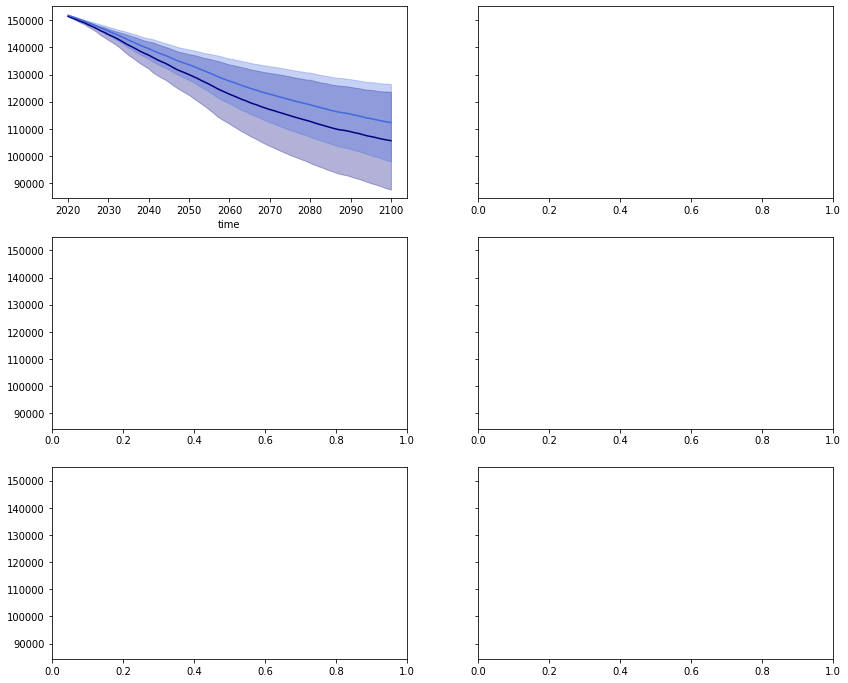

In [21]:
f, axs = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axs = np.array(axs).flatten()
for ssp, ax in zip(sorted(df_meta.ssp.unique()), axs):
    for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
        idir = base_dir + f'volume/{exp}/global/'
        df = pd.read_csv(idir + f'{ssp}.csv', index_col=0)
        avg = df.mean(axis=1) * 1e-9
        std = df.std(axis=1) * 1e-9
        ax.fill_between(avg.index, avg-std, avg+std, alpha=0.3, color=c)
        avg.plot(ax=ax, label=exp, c=c);
    ax.set_title(ssp)
ax.legend();
plt.tight_layout();

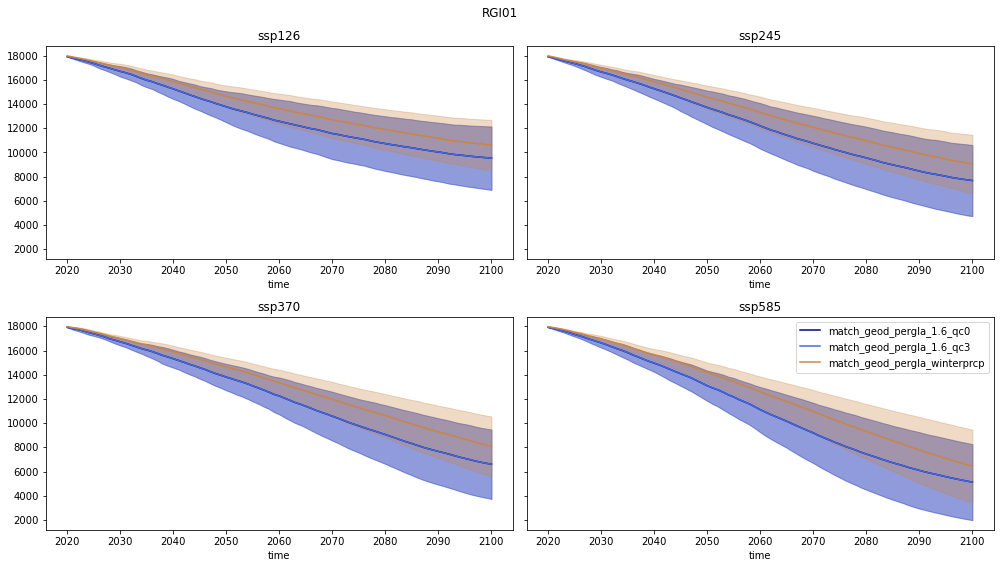

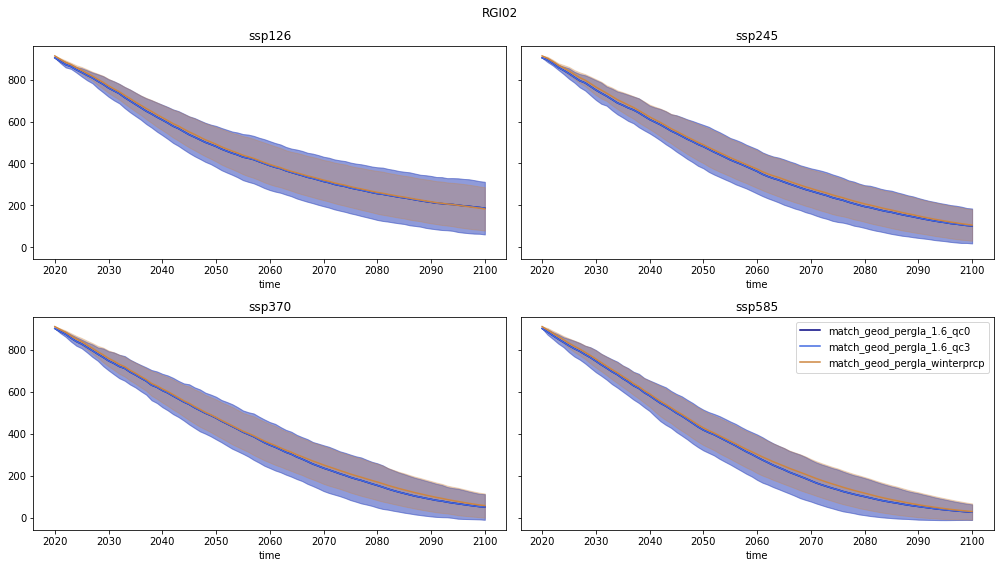

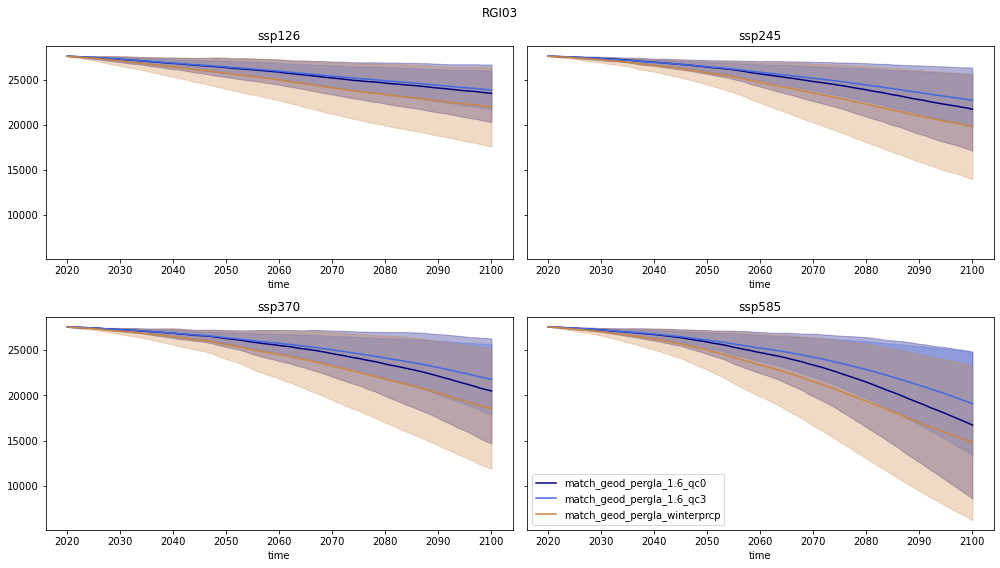

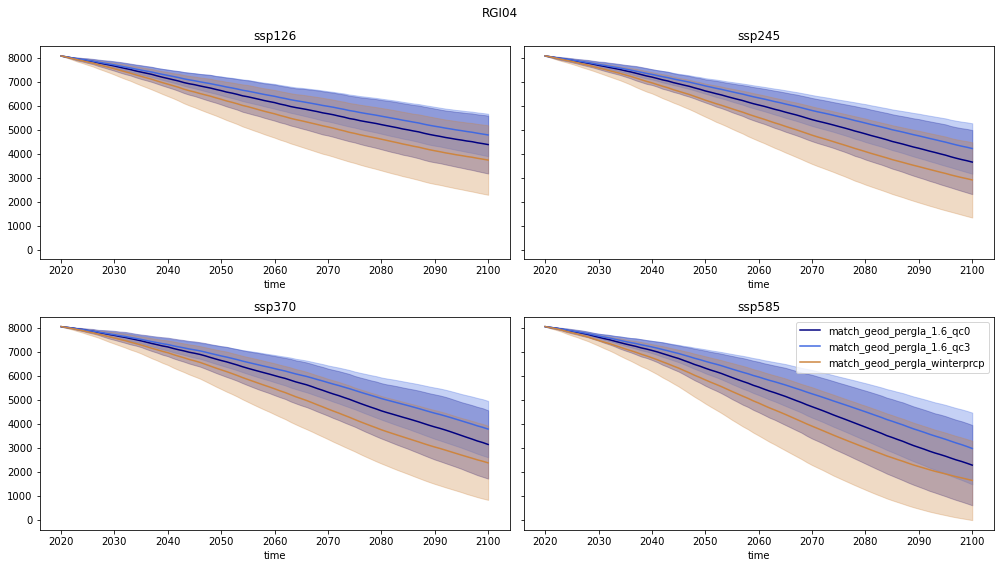

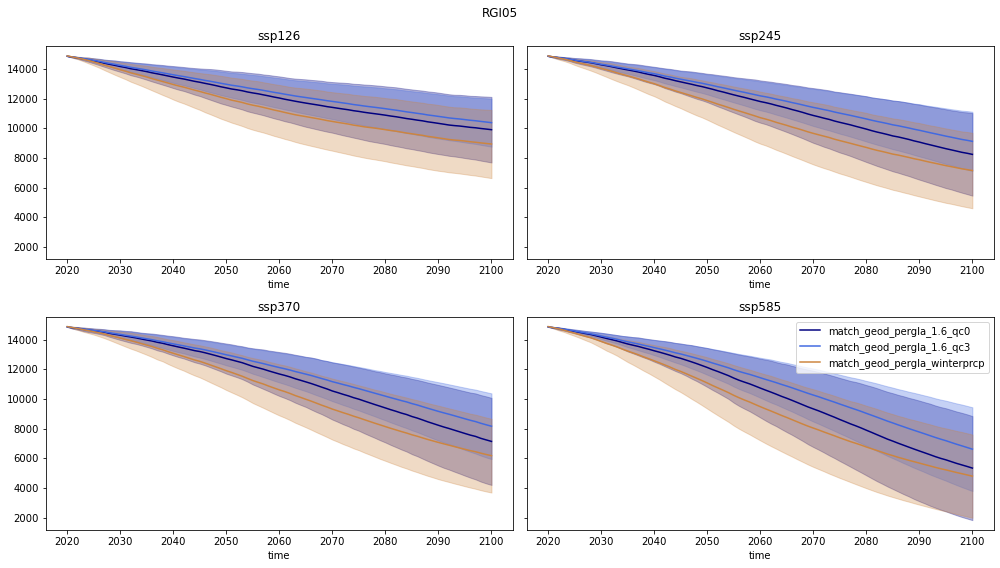

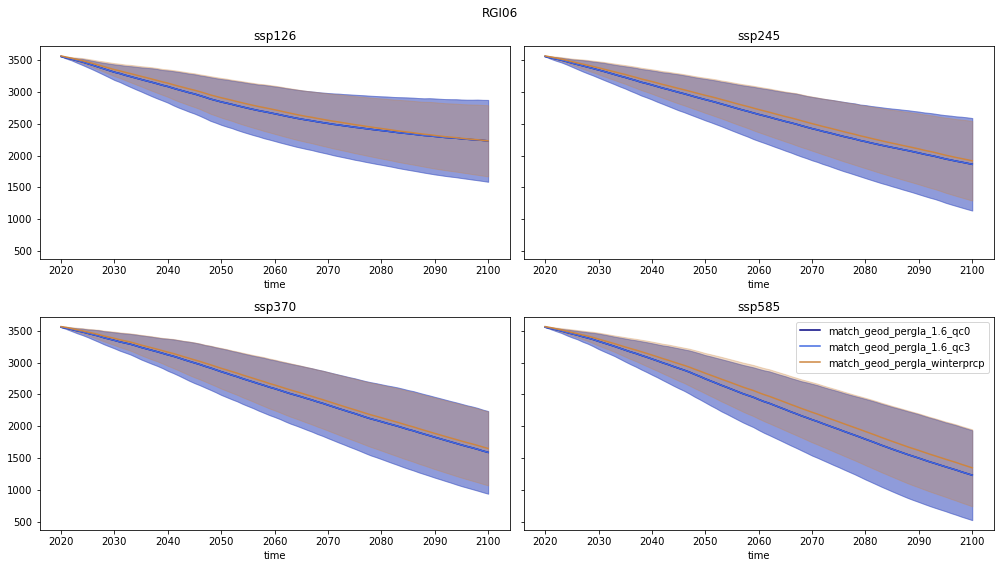

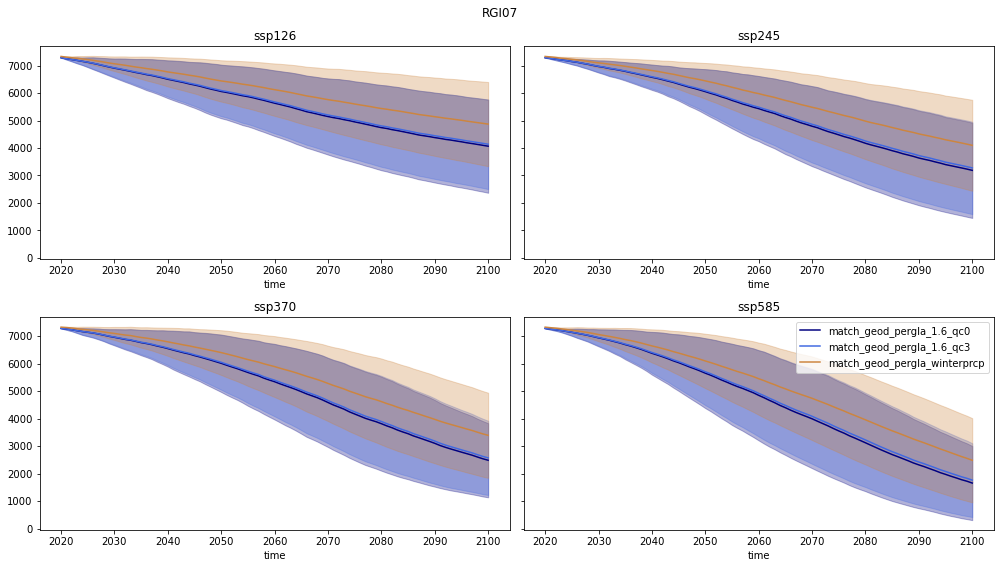

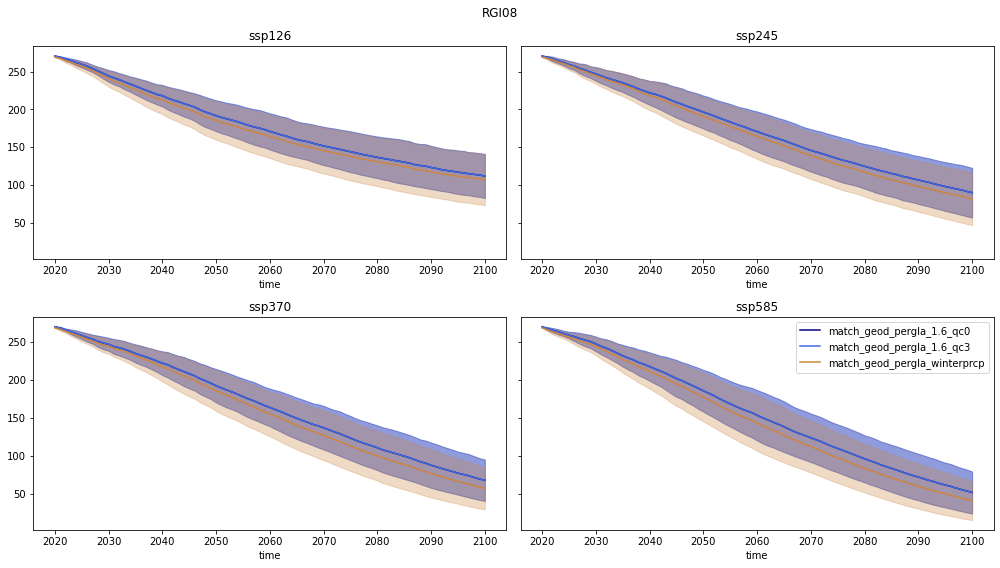

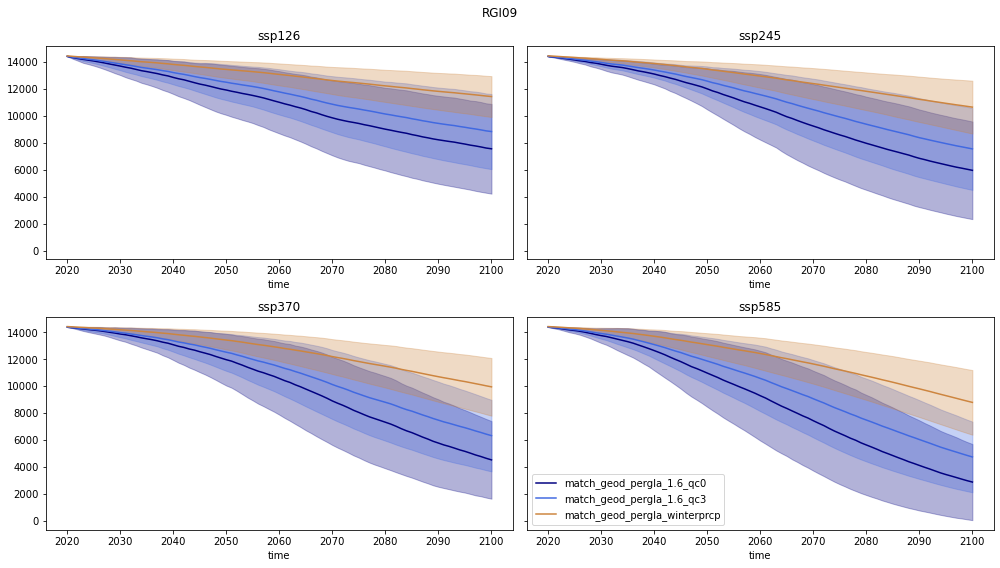

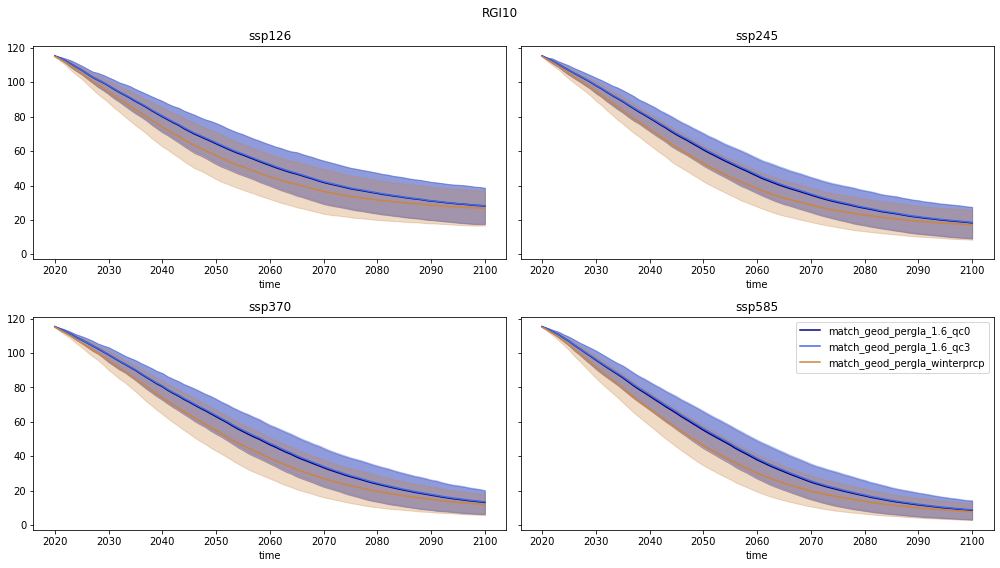

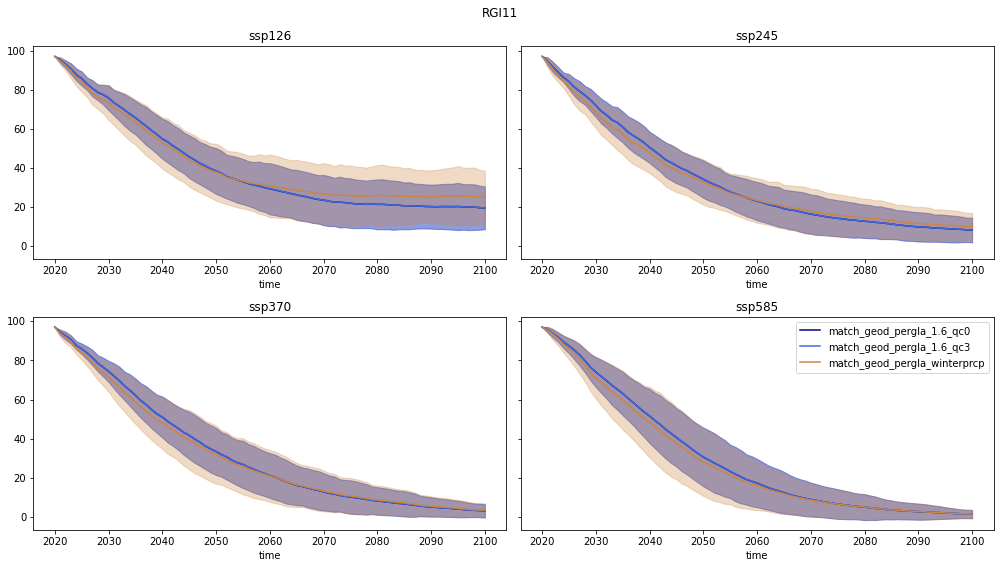

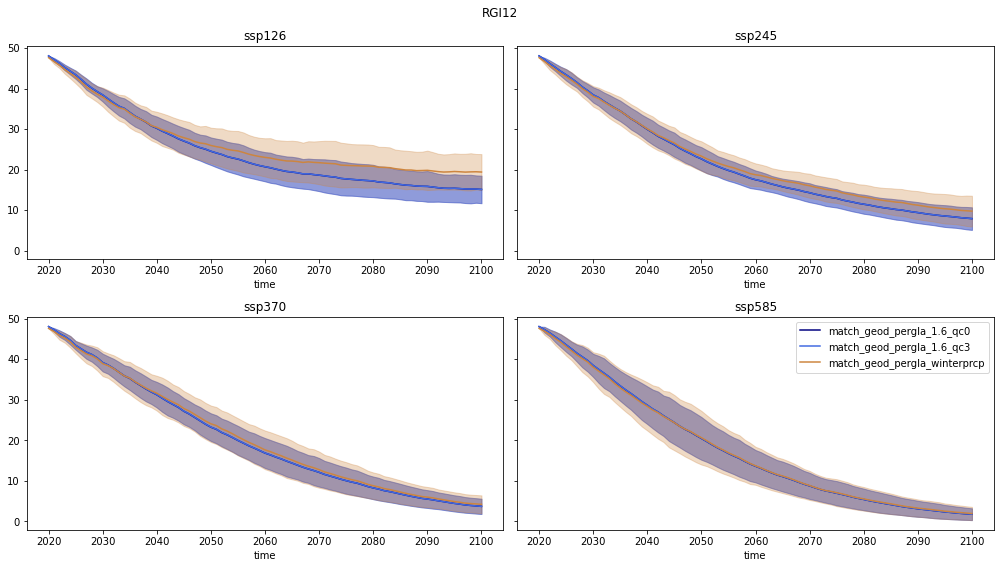

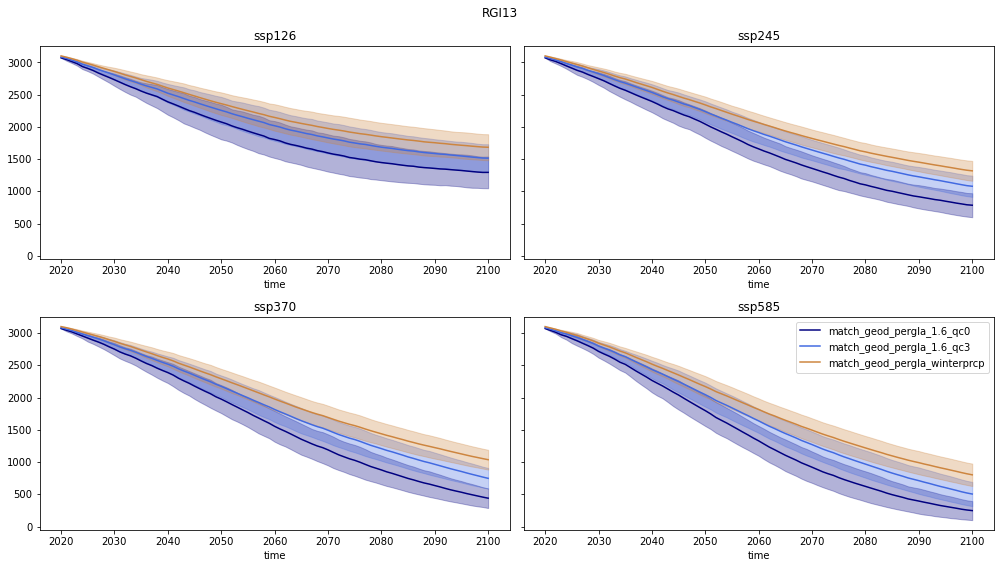

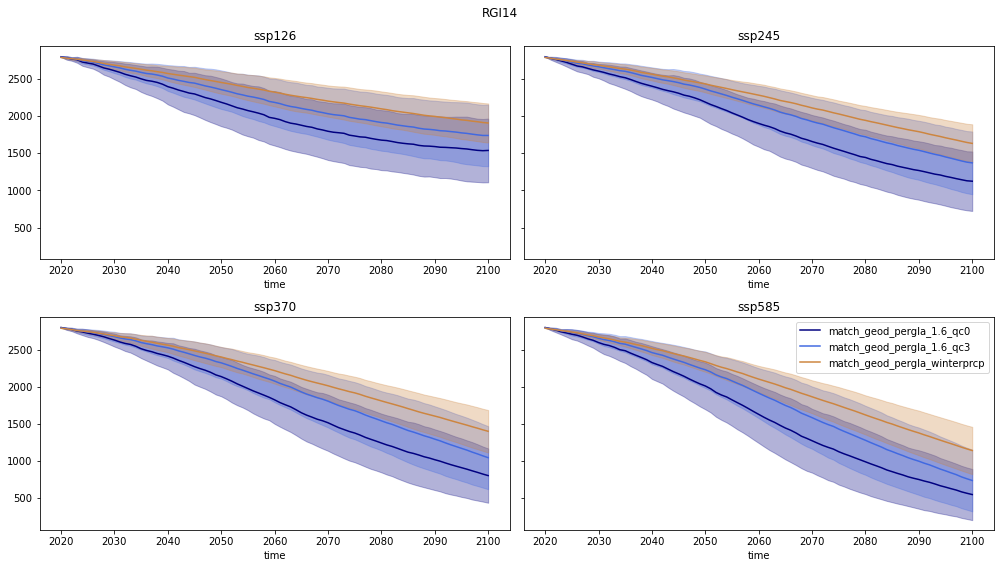

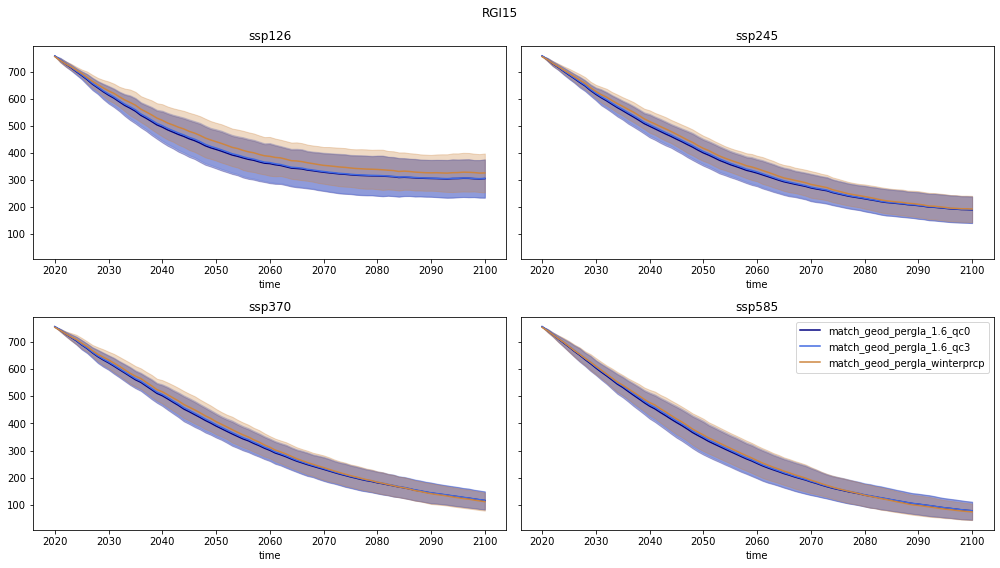

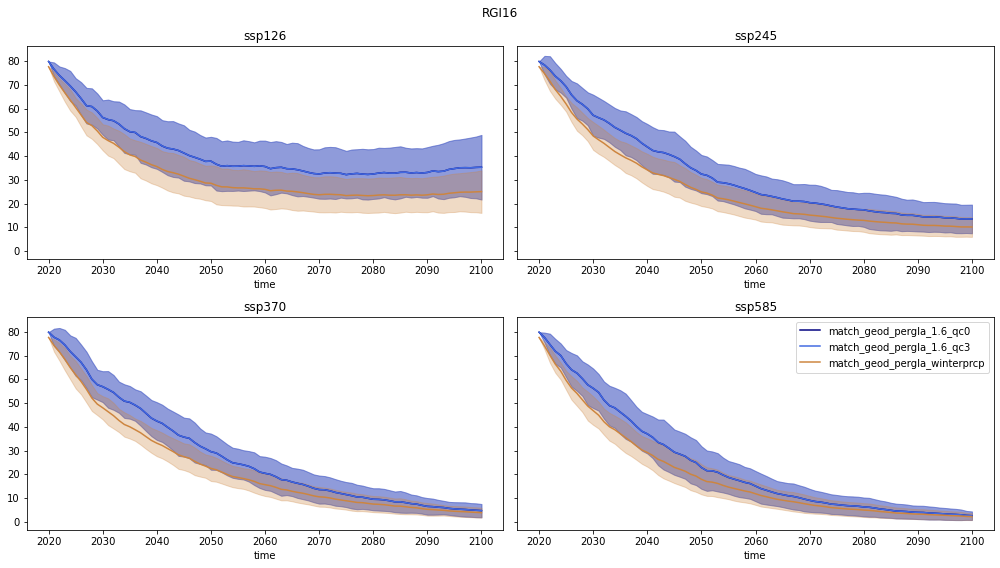

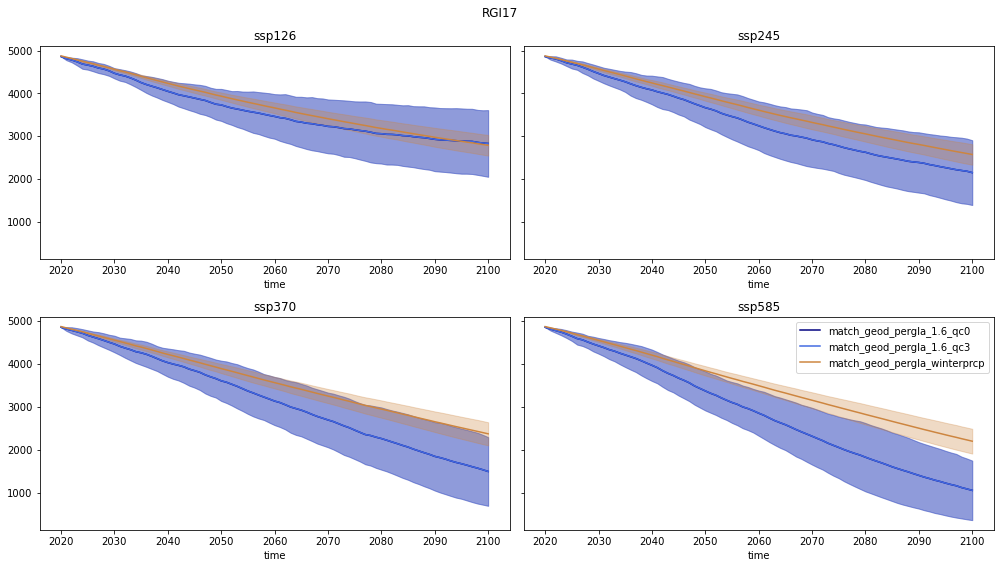

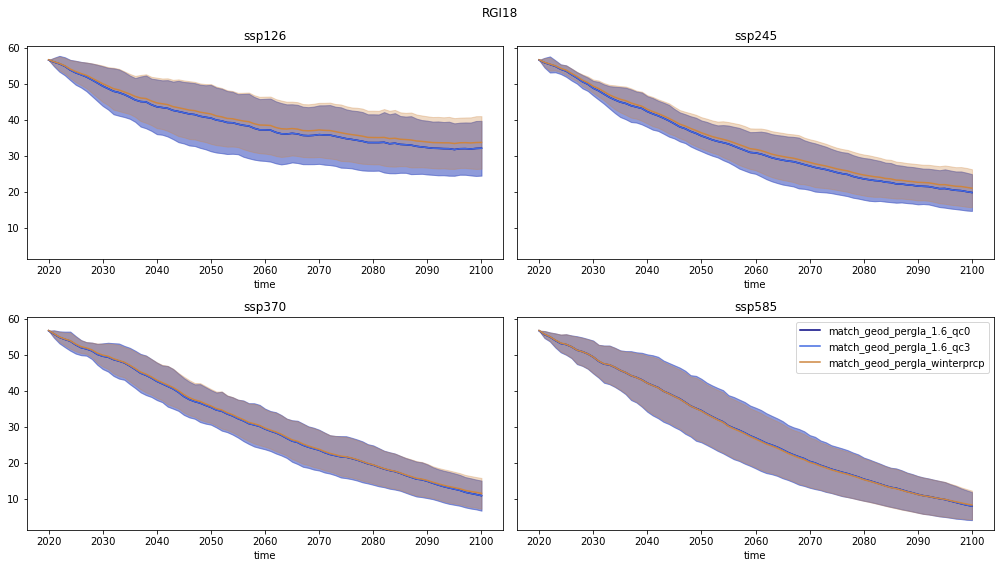

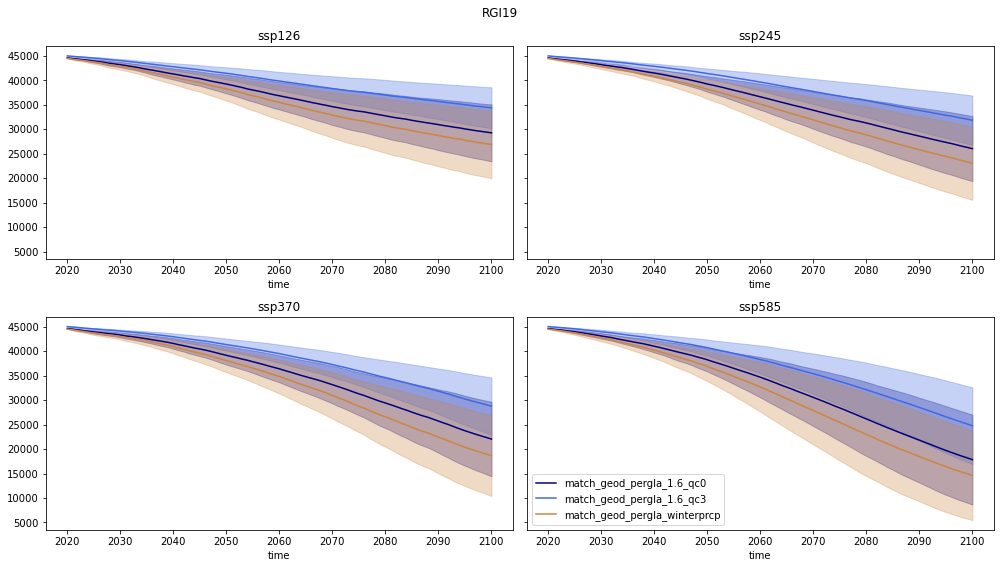

In [28]:
for reg in sorted(df_meta.rgi_reg.unique()):
    f, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
    axs = np.array(axs).flatten()
    for ssp, ax in zip(sorted(df_meta.ssp.unique())[1:], axs):
        for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
            idir = base_dir + f'volume/{exp}/{reg}/'
            df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0)
            avg = df.mean(axis=1) * 1e-9
            std = df.std(axis=1) * 1e-9
            ax.fill_between(avg.index, avg-std, avg+std, alpha=0.3, color=c)
            avg.plot(ax=ax, label=exp, c=c);
        ax.set_title(ssp)
    ax.legend();
    plt.suptitle(reg)
    plt.tight_layout();

### Historical - aggregation 

In [25]:
base_dir = 'historical/agg/'

In [26]:
for exp in df_meta.exp.unique():
    odf_v = pd.DataFrame()
    odf_a = pd.DataFrame()
    for rgi_reg in progressbar.progressbar(sorted(df_meta.rgi_reg.unique())):
        f = f'historical/{exp}/historical_run_output_extended_{rgi_reg[-2:]}.nc'
        with xr.open_dataset(f) as ds:
            volume = ds.volume.load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
            odf_v[rgi_reg] = volume.sum(dim='rgi_id').to_series()
            area = ds.area.load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
            odf_a[rgi_reg] = area.sum(dim='rgi_id').to_series()
    odir = base_dir + f'volume/{exp}/'
    mkdir(odir)
    odf_v.to_csv(odir + f'historical.csv')
    odir = base_dir + f'area/{exp}/'
    mkdir(odir)
    odf_a.to_csv(odir + f'historical.csv')

100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


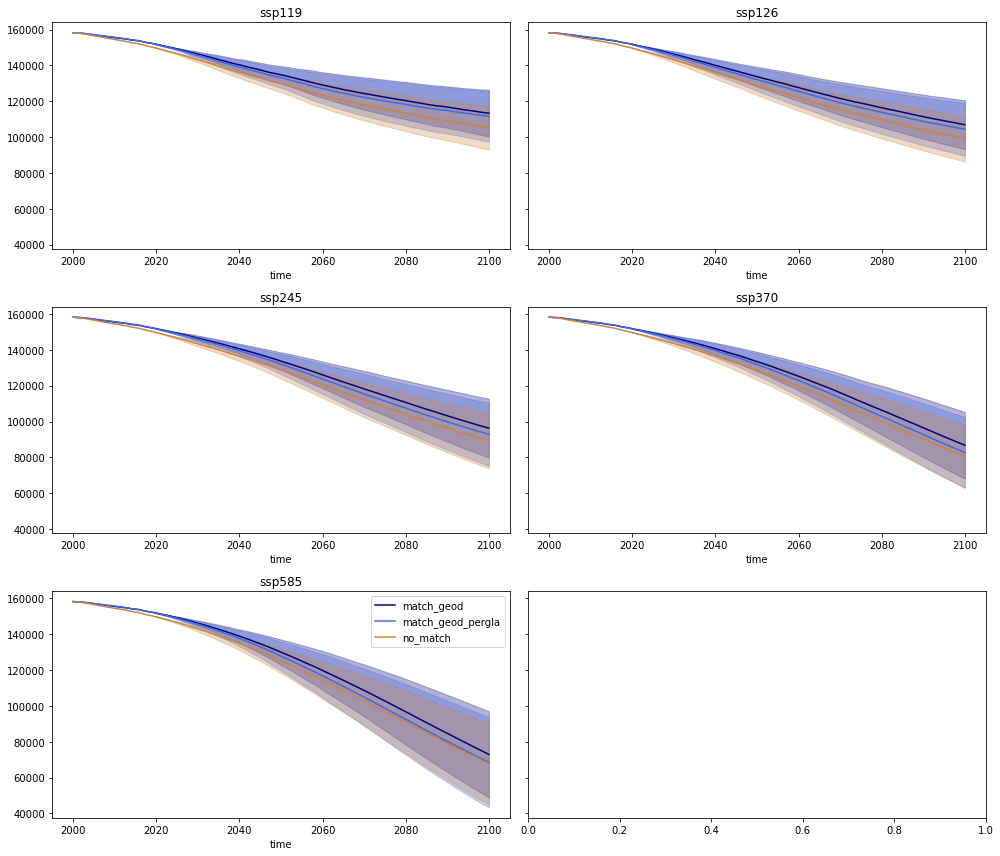

In [28]:
base_dir_gcm = 'agg/'
base_dir_hist = 'historical/agg/'

f, axs = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axs = np.array(axs).flatten()
for ssp, ax in zip(sorted(df_meta.ssp.unique()), axs):
    for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
        idir = base_dir_hist + f'volume/{exp}/'
        df = pd.read_csv(idir + f'/historical.csv', index_col=0)
        glob = df.sum(axis=1) * 1e-9
        glob.loc[2000:].plot(ax=ax, label='', c=c);
        
        idir = base_dir_gcm + f'volume/{exp}/global/'
        df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0)
        avg = df.mean(axis=1) * 1e-9
        std = df.std(axis=1) * 1e-9
        ax.fill_between(avg.index, avg-std, avg+std, alpha=0.3, color=c)
        avg.plot(ax=ax, label=exp, c=c);
    ax.set_title(ssp)
ax.legend();
plt.tight_layout();

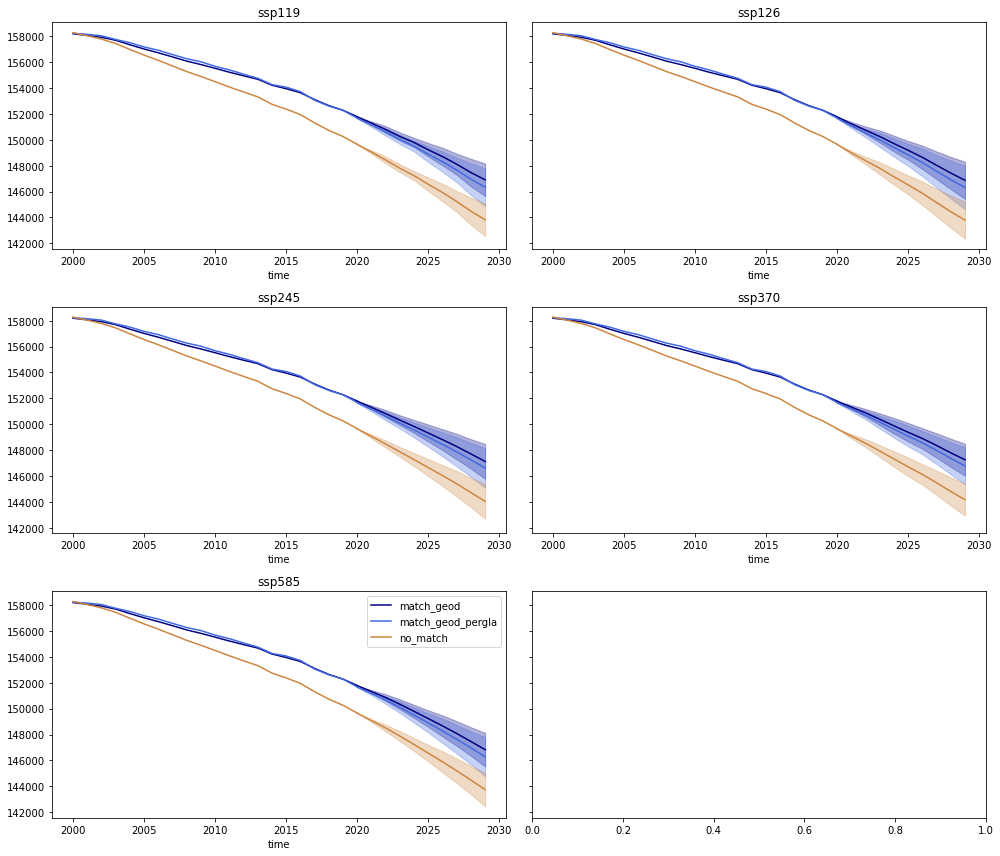

In [30]:
base_dir_gcm = 'agg/'
base_dir_hist = 'historical/agg/'

f, axs = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axs = np.array(axs).flatten()
for ssp, ax in zip(sorted(df_meta.ssp.unique()), axs):
    for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
        idir = base_dir_hist + f'volume/{exp}/'
        df = pd.read_csv(idir + f'/historical.csv', index_col=0)
        glob = df.sum(axis=1) * 1e-9
        glob.loc[2000:].plot(ax=ax, label='', c=c);
        
        idir = base_dir_gcm + f'volume/{exp}/global/'
        df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0).iloc[:10]
        avg = df.mean(axis=1) * 1e-9
        std = df.std(axis=1) * 1e-9
        ax.fill_between(avg.index, avg-std, avg+std, alpha=0.3, color=c)
        avg.plot(ax=ax, label=exp, c=c);
    ax.set_title(ssp)
ax.legend();
plt.tight_layout();